In [15]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud textblob gensim tensorflow flask flask-cors

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

# Download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Load real news with more robust settings
try:
    # For newer pandas versions
    true_news = pd.read_csv('true.csv', quotechar='"', on_bad_lines='skip')
except TypeError:
    # For older pandas versions
    true_news = pd.read_csv('true.csv', quotechar='"', error_bad_lines=False)

# Check if the data loaded properly
print(f"True news dataset shape: {true_news.shape}")
print(f"True news columns: {true_news.columns.tolist()}")

# Add label
true_news['label'] = 1  # 1 for real news

# Load fake news with the same robust settings
try:
    # For newer pandas versions
    fake_news = pd.read_csv('fake.csv', quotechar='"', on_bad_lines='skip')
except TypeError:
    # For older pandas versions
    fake_news = pd.read_csv('fake.csv', quotechar='"', error_bad_lines=False)

# Check if the data loaded properly
print(f"Fake news dataset shape: {fake_news.shape}")
print(f"Fake news columns: {fake_news.columns.tolist()}")

# Add label
fake_news['label'] = 0  # 0 for fake news

# Make sure both datasets have the same columns before concatenating
common_columns = list(set(true_news.columns).intersection(set(fake_news.columns)))
print(f"Common columns: {common_columns}")

# Use only the common columns for both datasets
true_news = true_news[common_columns]
fake_news = fake_news[common_columns]

# Combine the datasets
news_df = pd.concat([true_news, fake_news], ignore_index=True)

# Display basic information
print(f"Combined dataset shape: {news_df.shape}")
news_df.head()

# Check for missing values
print("\nMissing values in each column:")
print(news_df.isnull().sum())

# Basic statistics
print("\nClass distribution:")
print(news_df['label'].value_counts())

True news dataset shape: (30609, 4)
True news columns: ['title', 'text', 'subject', 'date']
Fake news dataset shape: (34629, 4)
Fake news columns: ['title', 'text', 'subject', 'date']
Common columns: ['date', 'text', 'label', 'title', 'subject']
Combined dataset shape: (65238, 5)

Missing values in each column:
date       0
text       0
label      0
title      0
subject    0
dtype: int64

Class distribution:
label
0    34629
1    30609
Name: count, dtype: int64


In [23]:
import nltk
nltk.download('punkt_tab') # Download the Punkt tab data
# Define preprocessing function
# Replace the existing preprocessing function with this faster version
def preprocess_text(text):
    if isinstance(text, str):
        # All operations in one go
        text = re.sub(r'http\S+|www\S+|https\S+|<.*?>|\d+|[^\w\s]', ' ', text.lower())
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

# Apply preprocessing
print("Preprocessing text data...")
news_df['clean_text'] = news_df['text'].apply(preprocess_text)

# Combine title and text for better feature representation
news_df['content'] = news_df['title'].apply(preprocess_text) + " " + news_df['clean_text']

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2])

news_df['processed_content'] = news_df['content'].apply(tokenize_and_lemmatize)

# Save preprocessed data for later use
news_df[['title', 'text', 'label', 'processed_content']].to_csv('preprocessed_news.csv', index=False)

# Display a sample of preprocessed text
print("\nSample of preprocessed text:")
print(news_df['processed_content'].iloc[0][:300] + "...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing text data...

Sample of preprocessed text:
budget fight loom republican flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking ...


In [24]:
# Split the dataset
X = news_df['processed_content']
y = news_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 52190
Testing set size: 13048


**Naive Bayes with TF-IDF**


In [25]:
from sklearn.naive_bayes import MultinomialNB

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

# Detailed evaluation
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

# Save the model
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump((nb_model, tfidf_vectorizer), f)

Naive Bayes Accuracy: 0.9341

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6926
           1       0.94      0.91      0.93      6122

    accuracy                           0.93     13048
   macro avg       0.93      0.93      0.93     13048
weighted avg       0.93      0.93      0.93     13048



Model 2: Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Detailed evaluation
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Save the model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump((rf_model, tfidf_vectorizer), f)

Random Forest Accuracy: 0.9993

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6926
           1       1.00      1.00      1.00      6122

    accuracy                           1.00     13048
   macro avg       1.00      1.00      1.00     13048
weighted avg       1.00      1.00      1.00     13048



Model 3: Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_lr = lr_model.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Detailed evaluation
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# Save the model
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump((lr_model, tfidf_vectorizer), f)

Logistic Regression Accuracy: 0.9898

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6926
           1       0.99      0.99      0.99      6122

    accuracy                           0.99     13048
   macro avg       0.99      0.99      0.99     13048
weighted avg       0.99      0.99      0.99     13048



Model 4: Deep Learning (LSTM)

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import pickle

# Assume X_train, X_test, y_train, y_test are already defined

# Tokenize the text data
max_words = 10000  # Set maximum number of words in vocabulary
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure the same input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build LSTM model - increase input_dim by 1 to accommodate the 0-10000 range
lstm_model = Sequential([
    Embedding(input_dim=max_words + 1, output_dim=128, input_length=max_len),  # Adjusted to max_words + 1
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
lstm_model.summary()

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Model Accuracy: {accuracy:.4f}")

# Predictions
y_pred_proba = lstm_model.predict(X_test_pad)
y_pred_lstm = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report for LSTM Model:")
print(classification_report(y_test, y_pred_lstm))

# Save model and tokenizer
lstm_model.save('lstm_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9380 - loss: 0.1818 - val_accuracy: 0.9916 - val_loss: 0.0262
Epoch 2/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9901 - loss: 0.0339 - val_accuracy: 0.9904 - val_loss: 0.0269
Epoch 3/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9944 - loss: 0.0190 - val_accuracy: 0.9933 - val_loss: 0.0224
Epoch 4/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9929 - val_loss: 0.0263
Epoch 5/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9970 - loss: 0.0108 - val_accuracy: 0.9943 - val_loss: 0.0291
Epoch 6/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9977 - loss: 0.0101 - val_accuracy: 0.9923 - val_loss: 0.0352
LSTM Model Accuracy: 0.9929
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step



Classification Report for LSTM Model:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      6926
         1.0       1.00      0.99      0.99      6122

    accuracy                           0.99     13048
   macro avg       0.99      0.99      0.99     13048
weighted avg       0.99      0.99      0.99     13048



Model Comparison and Visualization

LSTM Model Accuracy: 0.9929


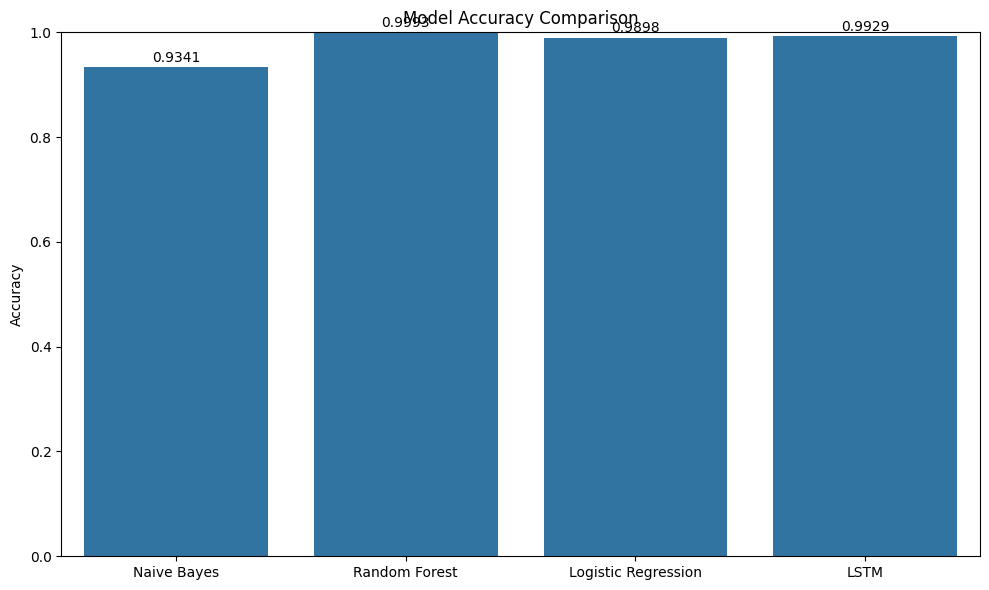

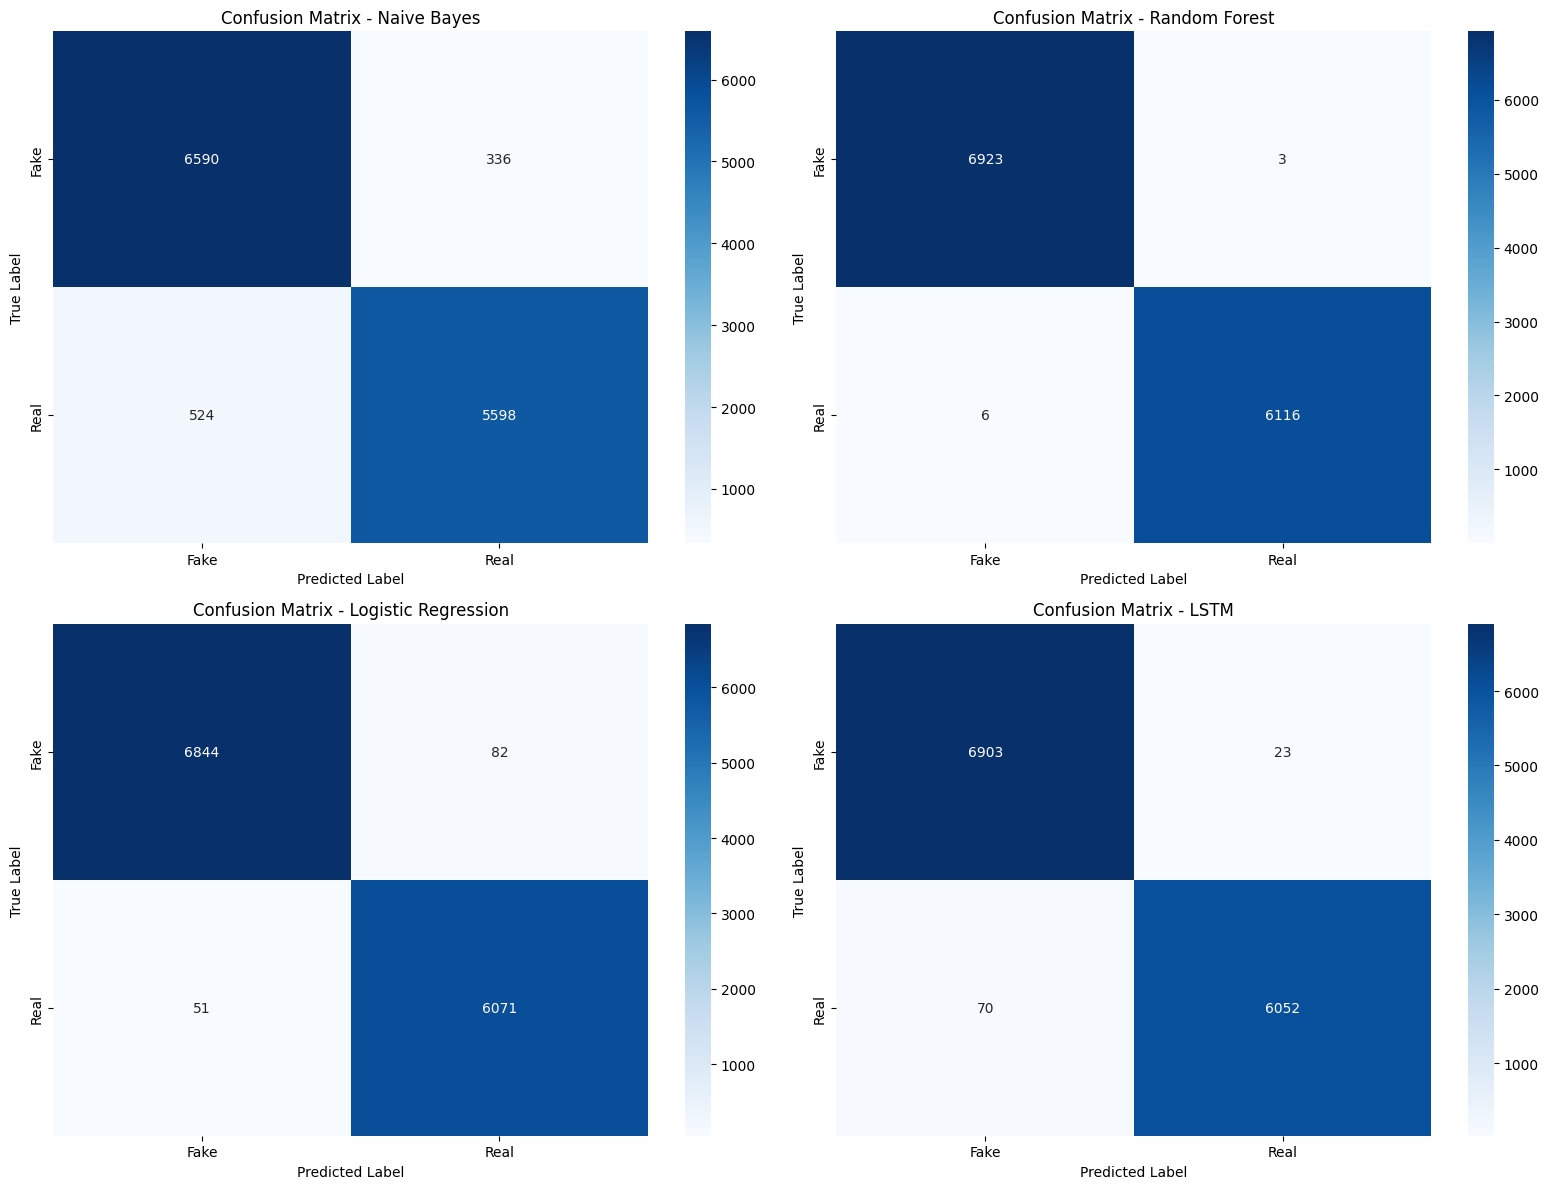

In [64]:
# After evaluating your LSTM model, you have:
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Model Accuracy: {accuracy:.4f}")

# Store the accuracy for comparison
accuracy_lstm = accuracy  # Save LSTM accuracy with a clear variable name

# Then for your results collection:
models = ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'LSTM']
accuracies = [accuracy_nb, accuracy_rf, accuracy_lr, accuracy_lstm]  # Use the saved variable

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Let's also visualize the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (model_name, y_pred) in enumerate(zip(
    models,
    [y_pred_nb, y_pred_rf, y_pred_lr, y_pred_lstm]
)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Fake', 'Real'],
        yticklabels=['Fake', 'Real'],
        ax=axes[i]
    )
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

Simple Web Application

In [71]:
%%writefile app.py
import pickle
import numpy as np
!pip install flask flask-cors pyngrok

from flask import Flask, request, jsonify, render_template
from flask_cors import CORS
!pip install flask flask-cors pyngrok

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize Flask app
app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the best model (let's assume Logistic Regression was best)
with open('logistic_regression_model.pkl', 'rb') as f:
    model, vectorizer = pickle.load(f)

# Preprocessing function (same as in training)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Tokenization and lemmatization function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2])

# Function to predict if news is real or fake
def predict_fake_news(title, content):
    # Combine title and content
    text = title + " " + content

    # Preprocess
    preprocessed_text = preprocess_text(text)
    final_text = tokenize_and_lemmatize(preprocessed_text)

    # Vectorize
    text_vectorized = vectorizer.transform([final_text])

    # Predict
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0][1]

    result = {
        "prediction": "Real" if prediction == 1 else "Fake",
        "probability": float(probability),
        "confidence": float(probability if prediction == 1 else 1 - probability)
    }

    return result

# Routes
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    title = data.get('title', '')
    content = data.get('content', '')

    result = predict_fake_news(title, content)
    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True)

Overwriting app.py


In [72]:
!mkdir -p templates

In [73]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Fake News Detector</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #f8f9fa;
            padding-top: 50px;
        }
        .container {
            max-width: 800px;
            background-color: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        .result-container {
            margin-top: 20px;
            padding: 20px;
            border-radius: 5px;
            display: none;
        }
        .real {
            background-color: #d4edda;
            border: 1px solid #c3e6cb;
            color: #155724;
        }
        .fake {
            background-color: #f8d7da;
            border: 1px solid #f5c6cb;
            color: #721c24;
        }
        .progress {
            height: 25px;
            margin-top: 10px;
        }
        h1 {
            color: #007bff;
            margin-bottom: 30px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1 class="text-center">Fake News Detector</h1>
        <p class="lead text-center mb-4">Enter a news article to check if it's real or fake</p>

        <form id="newsForm">
            <div class="mb-3">
                <label for="title" class="form-label">News Title:</label>
                <input type="text" class="form-control" id="title" placeholder="Enter the title of the news article" required>
            </div>

            <div class="mb-3">
                <label for="content" class="form-label">News Content:</label>
                <textarea class="form-control" id="content" rows="6" placeholder="Enter the content of the news article" required></textarea>
            </div>

            <div class="d-grid">
                <button type="submit" class="btn btn-primary">Check News</button>
            </div>
        </form>

        <div id="loading" class="text-center mt-4" style="display: none;">
            <div class="spinner-border text-primary" role="status">
                <span class="visually-hidden">Loading...</span>
            </div>
            <p>Analyzing...</p>
        </div>

        <div id="resultContainer" class="result-container">
            <h4 id="resultText" class="mb-3"></h4>
            <p>Confidence Level:</p>
            <div class="progress">
                <div id="confidenceBar" class="progress-bar" role="progressbar" style="width: 0%"></div>
            </div>
            <p id="confidenceText" class="mt-2"></p>
        </div>
    </div>

    <script>
        document.getElementById('newsForm').addEventListener('submit', async function(e) {
            e.preventDefault();

            const title = document.getElementById('title').value;
            const content = document.getElementById('content').value;

            // Show loading
            document.getElementById('loading').style.display = 'block';
            document.getElementById('resultContainer').style.display = 'none';

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json'
                    },
                    body: JSON.stringify({ title, content })
                });

                const result = await response.json();

                // Update UI
                const resultContainer = document.getElementById('resultContainer');
                const resultText = document.getElementById('resultText');
                const confidenceBar = document.getElementById('confidenceBar');
                const confidenceText = document.getElementById('confidenceText');

                // Set result text and styling
                if (result.prediction === 'Real') {
                    resultContainer.className = 'result-container real';
                    resultText.textContent = '✓ This news appears to be REAL';
                    confidenceBar.className = 'progress-bar bg-success';
                } else {
                    resultContainer.className = 'result-container fake';
                    resultText.textContent = '✗ This news appears to be FAKE';
                    confidenceBar.className = 'progress-bar bg-danger';
                }

                // Set confidence level
                const confidencePercent = Math.round(result.confidence * 100);
                confidenceBar.style.width = `${confidencePercent}%`;
                confidenceBar.textContent = `${confidencePercent}%`;
                confidenceText.textContent = `Our model is ${confidencePercent}% confident in this prediction.`;

                // Show result
                document.getElementById('loading').style.display = 'none';
                resultContainer.style.display = 'block';

            } catch (error) {
                console.error('Error:', error);
                alert('An error occurred while analyzing the news. Please try again.');
                document.getElementById('loading').style.display = 'none';
            }
        });
    </script>
</body>
</html>

Writing templates/index.html


In [75]:
%%writefile README.md
# Fake News Detection System

This project uses machine learning and natural language processing to classify news articles as real or fake. The system implements multiple classification models and provides a web interface for real-time detection.

## Models Implemented

1. Naive Bayes with TF-IDF
2. Random Forest
3. Logistic Regression
4. LSTM Deep Learning Model

## Dataset

The dataset used for this project is from Kaggle, containing labeled real and fake news articles.

## Project Structure

Writing README.md


In [135]:


!ls












MessageError: Error: credential propagation was unsuccessful